In [1]:
import torch
from safetensors import safe_open
from transformers import AutoModelForMaskedLM, AutoTokenizer
from datasets import load_dataset
from genplasmid.dataset import read_genbank, genbank_to_glm2
import pandas as pd
%config InlineBackend.figure_format = 'retina'


/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# Load the YFP vector dataset
yfp_vector = load_dataset("wconnell/openplasmid")
yfp_vector = yfp_vector.filter(lambda x: '127546' == x['ID'])
yfp_vector = yfp_vector['train'][0]

# Parse the GenBank file
yfp_gbank = read_genbank(yfp_vector['GenBank Raw'])

# Convert GenBank to GLM2 sequence
yfp_glm2 = genbank_to_glm2(yfp_vector['GenBank Raw'])

# Find the primer binding site
primer_bind = yfp_gbank.features[6]
primer_bind_seq = str(yfp_gbank.seq[primer_bind.location.start:primer_bind.location.end].lower())

# Create the masked sequence
# NOTE: this does not include the proximal/distal primer binding sites
mask_len = 110
use_primer = False

mask_start = yfp_glm2.find(primer_bind_seq)
mask_start = mask_start + len(primer_bind_seq) + 3  # buffer for '<+>'
mask_insert = ''.join(['<mask>'] * mask_len)

if use_primer:
    primer_distal = 'GCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATTTTTTTCACATC'.lower()
    primer_proximal = 'GGTTACGGCTGTTTCTTAATTAAAAAAAGATAGAAAACATTAGGAGTGTAACACAAGACTTTCGGATCCTGAGCAGGCAAGATAAACGA'.lower()
    masked_yfp_glm2 = yfp_glm2[:mask_start] + primer_distal + mask_insert + primer_proximal + '<+>' + yfp_glm2[mask_start:]
    mask_start = mask_start + len(primer_distal)
    mask_end = mask_start + mask_len
else:
    masked_yfp_glm2 = yfp_glm2[:mask_start] + mask_insert + '<+>' + yfp_glm2[mask_start:]
    mask_end = mask_start + mask_len

# Find the YFP CDS
yfp_cds = yfp_gbank.features[7]
yfp_cds_seq = yfp_cds.qualifiers['translation'][0]

# Load variants
variants = pd.read_csv('results/seq_variants/variants.csv')
variants =variants[variants['Backbone_RMSD'] < 5]
# add original plasmid to variants
original_plasmid = pd.DataFrame([{'ID': 127546, 'Masking_Percentage': 0, 'Sequence_used': True, 'Generated_Sequence': yfp_cds_seq, 'Sequence_Identity': 1.0, 'Backbone_RMSD': 0}])
variants = pd.concat([original_plasmid, variants])

# Create masked_yfp_var_glm2 for all sequences
variant_plasmids = []

for _, row in variants.iterrows():
    cds_insert = row['Generated_Sequence']
    start = masked_yfp_glm2.find(yfp_cds_seq)
    end = start + len(yfp_cds_seq)
    masked_yfp_var_glm2 = masked_yfp_glm2[:start] + cds_insert + masked_yfp_glm2[end:]
    variant_plasmid = {'ID': row['ID'], 'glm2_sequence': masked_yfp_var_glm2}
    variant_plasmids.append(variant_plasmid)


In [40]:
primer_bind_seq
primer_distal
variant_plasmids[0]['glm2_sequence']

'ccagtttggaacaagagtccac'

'gctagcaggaatgatgcaaaaggttcccgattcgaactgcatttttttcacatc'

'<+>gaagcgcctacgcttgacatctactatatgtaagtatacggccccatatataggccctttcgtctcgcgcgtttcggtgatgacggtgaaaa<+>cctctgacacatgcagctcccgg<+>atttaggtgacactataga<+>atttaggtgacactatag<+>ttcaattcatcattttttttttattcttttttttgatttcggtttccttgaaatttttttgattcggtaatctccgaacagaaggaagaacgaaggaaggagcacagacttagattggtatatatacgcatatgtagtgttgaagaaacatgaaattgcccagtattcttaacccaactgcacagaacaaaaacctgcaggaaacgaagataaatc<+>MSKATYKERAATHPSPVAAKLFNIMHEKQTNLCASLDVRTTKELLELVEALGPKICLLKTHVDILTDFSMEGTVKPLKALSAKYNFLLFEDRKFADIGNTVKLQYSAGVYRIAEWADITNAHGVVGPGIVSGLKQAAEEVTKEPRGLLMLAELSCKGSLSTGEYTKGTVDIAKSDKDFVIGFIAQRDMGGRDEGYDWLIMTPGVGLDDKGDALGQQYRTVDDVVSTGSDIIIVGRGLFAKGRDAKVEGERYRKAGWEAYLRRCGQQN<+>ccagtttggaacaagagtccac<+><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask>

In [41]:
yfp_cds_seq

'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKLICTTGKLPVPWPTLVTTLGYGLQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGGVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [42]:
checkpoint_path = "results/finetune/20241013_122705-70ecfce3-2125-4b7d-b193-ff07095d7781/checkpoints/checkpoint-13152/model.safetensors"
# checkpoint_path = None

tokenizer = AutoTokenizer.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True)

# Load finetuned model
if checkpoint_path:
    print("Loading finetuned model")
    model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', torch_dtype=torch.bfloat16, trust_remote_code=True).cuda()
    # Load the safetensors file
    with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
        state_dict = {k: f.get_tensor(k) for k in f.keys()}

    # Load the state dict into the model
    incompatible_keys = model.load_state_dict(state_dict, strict=False)
    print(incompatible_keys)
else:
    print("Loading pretrained model")
    model = AutoModelForMaskedLM.from_pretrained('tattabio/gLM2_150M', trust_remote_code=True).cuda()

# Define a function to tokenize the sequences
def tokenize_function(examples):
    return tokenizer(examples['glm2_sequence'], truncation=True, padding='max_length', max_length=4096)

Loading finetuned model
<All keys matched successfully>


In [43]:
from datasets import Dataset
from torch.utils.data import DataLoader
variant_plasmid_ds = Dataset.from_list(variant_plasmids)
variant_plasmid_ds = variant_plasmid_ds.map(tokenize_function, batched=True)
variant_plasmid_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ID'])
dataloader = DataLoader(variant_plasmid_ds, batch_size=5, shuffle=False)
    

Map: 100%|██████████| 2646/2646 [00:05<00:00, 484.52 examples/s]


In [44]:
# Set the model to evaluation mode
device = 'cuda:1'
_ = model.to(device)
_ = model.eval()

predictions = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        logits = outputs.logits
        
        # Generate predicted sequences
        predicted_token_ids = torch.argmax(logits, dim=-1)
        predicted_sequences = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=False)
        # replace ' ' with ''
        predicted_sequences = [p.replace(" ", "") for p in predicted_sequences]
        predictions.extend(predicted_sequences)
    if i == 10:
        break

# Print a sample of predictions
print("Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(pred)

Sample predictions:
<+>gaagcgcctacgcttgacatctactatatgtaagtatacggccccatatataggccctttcgtctcgcgcgtttcggtgatgacggtgaaaa<+>cctctgacacatgcagctcccgg<+>atttaggtgacactataga<+>atttaggtgacactatag<+>ttcaattcatcatttttttttttttctttttttttatttcggtttccttgaaatttttttgattcggtaatctccgaacagaaggaagaacgaaggaaggagcacagacttagattggtatatatatgcatatgtagtgttgaagaaacatgaaattgcccagtattcttaacccaactgcacagaacaaaaacctgcaggaaacgaagataaatc<+>MSKATYKERVATHPSPVAARLFNIMHEKQTNLCASLDVRNTKELLELVEALGPKICLLKTHVDILTDFSMEGGVKALKALSAKYNFLLFEDRKFADIGNTVKLQYSAGVYRIAEWADITNAHGVVGPGIVSGLKQAAEEVTKEPRGLLMLAELSCKGSLSTGEYTKSVVEIAKQDPDFVIGFIAQRDMGGRDEGSDFLIATPGVGLDDKGDALGQQYRTVDDVVNTGSDILIVGRGLFAKGRDAKVEAERLRKAAWEAYLRRTGQQN<+>ccagtttggaacaagagtccaccMLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALLLLALLAAAAALLLALALLLLLLLLLLLLLAAAAAAAAAALLE<+><+>K<+>MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKLICTTGKLPVPWPTLVTTLTYGLQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGGVQLADHYQQ

In [45]:
for p in predictions:
    print(p[mask_start:mask_end])

LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALLLLALLAAAAALLLALALLLLLLLLLLLLLAAAAAAAAAALLE<+><+
MALLLLLLLLLLLLLLLLLLLLLALLLLLLLLLLLALLLLLLALLLLAAAAAALLAALLALAALLLALLLLLLLALLAAALALALLLLALLLLLLLLLLGGGLGLLL<+>
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALALLALLLLLAAALLLAAAALLALLLLLALLLLLALALLLLLLLLLGGELEEELE<+
gLLLLLLLLLLLLLLLLLLALLLLLLLLLLLLLLLLLLLLLLLALLLLLLAALLLLLLAALLLALALALLLLALALLAALLAALLLLLLAALLLLLLLLLLLLLLLLLAA
LLLLLLLLLLLLLLLALLLLALLLLLLLLLLLLLLLLLALLLLLLAAALALLALLAALLLLALAALLALAAALLLALAALALLLLLAALLALLLLLLLALLLLAAAALGK
MALLLLLLLLLLLLLLLLALLLLLLLLLLLLLALLLLLALAALLLAALLLAAAALAAAALAALLAAALLLLLAALALLLAALLALAALLLLLLLLLLLLALLLLLEELLL
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALLLLALLLALLALAALALALLLAAAAALLLLALLALALLLLLLLALLLLLLLLLLLLLADGR
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALLLLLLLLALLALAAAAAAAAALALLAALAAAALAAAAAAAAAAALLAAAALLALALAALLLAAGLAAAAALAGK
MALLLLLLLLLLLLLLLLALLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLALLLALLLALLLLLLAAAAALLLAAALAALLAAAAALLLLAAAAAALLLALA<+
L

## Alt backbone, YFP variants
Static mask original promoter with YFP variants in context

In [51]:
yfp_vector = load_dataset("wconnell/openplasmid")
yfp_vector = yfp_vector.filter(lambda x: '13033' == x['ID'])
yfp_vector = yfp_vector['train'][0]

# Parse the GenBank file
yfp_gbank = read_genbank(yfp_vector['GenBank Raw'])

# Convert GenBank to GLM2 sequence
yfp_glm2 = genbank_to_glm2(yfp_vector['GenBank Raw'])

Filter: 100%|██████████| 147071/147071 [00:18<00:00, 7762.43 examples/s]


In [92]:
import random

# Find the promoter site
promoter = yfp_gbank.features[3]
promoter_seq = str(yfp_gbank.seq[promoter.location.start:promoter.location.end].lower())
promoter_seq

mask_len = 110
replace_promoter = False

mask_start = yfp_glm2.find(promoter_seq)
mask_start = mask_start + len(promoter_seq) + 3  # buffer for '<+>'

if replace_promoter:
    mask_insert = ''.join(['<mask>'] * mask_len)
    masked_yfp_glm2 = yfp_glm2[:mask_start] + mask_insert + '<+>' + yfp_glm2[mask_start:]
    mask_end = mask_start + mask_len
else:
    # Randomly replace n% of promoter_seq positions with '<mask>'
    masked_promoter = list(promoter_seq)
    mask_positions = random.sample(range(len(promoter_seq)), k=int(0.5 * len(promoter_seq)))
    for pos in mask_positions:
        masked_promoter[pos] = '<mask>'
    masked_promoter = ''.join(masked_promoter)
    masked_yfp_glm2 = yfp_glm2[:mask_start] + masked_promoter + '<+>' + yfp_glm2[mask_start:]
    mask_end = mask_start + len(promoter_seq)

# Find the YFP CDS
yfp_cds = yfp_gbank.features[7]
yfp_cds_seq = yfp_cds.qualifiers['translation'][0]

# Load variants
variants = pd.read_csv('results/seq_variants/variants.csv')
variants =variants[variants['Backbone_RMSD'] < 5]
# add original plasmid to variants
original_plasmid = pd.DataFrame([{'ID': 127546, 'Masking_Percentage': 0, 'Sequence_used': True, 'Generated_Sequence': yfp_cds_seq, 'Sequence_Identity': 1.0, 'Backbone_RMSD': 0}])
variants = pd.concat([original_plasmid, variants])

# Create masked_yfp_var_glm2 for all sequences
variant_plasmids = []

for _, row in variants.iterrows():
    cds_insert = row['Generated_Sequence']
    start = masked_yfp_glm2.find(yfp_cds_seq)
    end = start + len(yfp_cds_seq)
    masked_yfp_var_glm2 = masked_yfp_glm2[:start] + cds_insert + masked_yfp_glm2[end:]
    variant_plasmid = {'ID': row['ID'], 'glm2_sequence': masked_yfp_var_glm2}
    variant_plasmids.append(variant_plasmid)


'gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct'

In [93]:
from datasets import Dataset
from torch.utils.data import DataLoader
variant_plasmid_ds = Dataset.from_list(variant_plasmids)
variant_plasmid_ds = variant_plasmid_ds.map(tokenize_function, batched=True)
variant_plasmid_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ID'])
dataloader = DataLoader(variant_plasmid_ds, batch_size=5, shuffle=False)
    

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map: 100%|██████████| 2646/2646 [00:05<00:00, 508.18 examples/s]


In [94]:
# Set the model to evaluation mode
device = 'cuda:1'
_ = model.to(device)
_ = model.eval()

predictions = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        logits = outputs.logits
        
        # Generate predicted sequences
        predicted_token_ids = torch.argmax(logits, dim=-1)
        predicted_sequences = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=False)
        # replace ' ' with ''
        predicted_sequences = [p.replace(" ", "") for p in predicted_sequences]
        predictions.extend(predicted_sequences)
    if i == 10:
        break

# Print a sample of predictions
print("Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(pred)

Sample predictions:
<+>tctacggatcgggagatctcccgatcccctatggtgcactctcag<+>tacaatctgctctgatgccg<+>gacattgattattgactagttattaatagtaatcaattacggggtcattagttcatagcccatatatggagttccgcgttacataacttacggtaaatggcccgcctggctgaccgcccaacgacccccgcccattgacgtcaataatgacgtatgttcccatagtaacgccaatagggactttccattgacgtcaatgggtggagtatttacggtaaactgcccacttggcagtacatcaagtgtatcatatgccaagtacgccccctattgacgtcaatgacggtaaatggcccgcctggcattatgcccagtacatgaccttatgggactttcctacttggcagtacatctacgtattagtcatcgctattaccatg<+>gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggagctctatataagcagagcttgtaatgcggttttggcagtacatcaatgggcgtggatagcggtctgaatcacggggatttccaagtctccaccccattgacgtcaatgggagttcgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactcaaccctattgacgccaatgggcgtatagcgtgtacggtgggaggtctatataagcagagct<+>cgcaaatgggcggtaggcgtg<+>taatacgactcactataggg<+>taatacgactcactatagg<+>MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK

In [95]:
promoter_seq

'gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct'

In [97]:
for p in predictions:
    print(p[mask_start:mask_end])

aatgcggttttggcagtacatcaatgggcgtggatagcggtctgaatcacggggatttccaagtctccaccccattgacgtcaatgggagttcgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactcaaccctattgacgccaatgggcgtatagcgtgtacggtgggaggtctatataagcagagct<+
aatgcggttttggcagtacatcaatgggcgtggatagcggtctgtatcacggggatttccaagtctccaccccattgacgtcaatgggagttcgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactcaaccctattgacgccaatgggcgtatagcgtgtacggtgggaggtctatataagcagagcg<+
aatgcggttttggcagtacatcaatgggcgtggatagcggtttgaatcacggggatttccaagtctccaccccattgacgtcaatgggagttcgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactcacccctattgacgccaaagggcgtatggcgtgtacggtgggaggtctatataagcagagct<+
aatgcggttttggcagtacatcaatgggcgtggatagcggtttgaatcacggggatttccaagtctccaccccattgacgtcaatgggagttcgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactcggccctattgacgccaatgggcgtatagcgtgtacggtgggaggtctatataagcagagct<+
aatgcggttttggcagtacatcaatgggcgtggatagcggtttgaatcacggggatttccaagtctccaccccattgacgtcaatgggagttcgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactcaaccctattgacgccaatgggcgtatagcgtgtacggtg

## Alt backbone, YFP original
Randomly mask original promoter with original YFP context

In [98]:
yfp_vector = load_dataset("wconnell/openplasmid")
yfp_vector = yfp_vector.filter(lambda x: '13033' == x['ID'])
yfp_vector = yfp_vector['train'][0]

# Parse the GenBank file
yfp_gbank = read_genbank(yfp_vector['GenBank Raw'])

# Convert GenBank to GLM2 sequence
yfp_glm2 = genbank_to_glm2(yfp_vector['GenBank Raw'])

In [104]:
import random

def mask_promoter(promoter_seq, mask_frac=0.15):
    # Randomly replace n% of promoter_seq positions with '<mask>'
    masked_promoter = list(promoter_seq)
    mask_positions = random.sample(range(len(promoter_seq)), k=int(mask_frac * len(promoter_seq)))
    for pos in mask_positions:
        masked_promoter[pos] = '<mask>'
    masked_promoter = ''.join(masked_promoter)
    return masked_promoter


# Find the promoter site
promoter = yfp_gbank.features[3]
promoter_seq = str(yfp_gbank.seq[promoter.location.start:promoter.location.end].lower())
promoter_seq

mask_start = yfp_glm2.find(promoter_seq)
mask_start = mask_start + len(promoter_seq) + 3  # buffer for '<+>'
mask_end = mask_start + len(promoter_seq)   

# Create masked_yfp_var_glm2 for all sequences
variant_promoters = []
n_samples = 2500

for i in range(n_samples):
    masked_promoter = mask_promoter(promoter_seq, mask_frac=0.15)
    masked_yfp_glm2 = yfp_glm2[:mask_start] + masked_promoter + '<+>' + yfp_glm2[mask_start:]
    variant_promoters.append({'ID': i, 'glm2_sequence': masked_yfp_glm2})

'gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct'

In [107]:
from datasets import Dataset
from torch.utils.data import DataLoader
variant_promoter_ds = Dataset.from_list(variant_promoters)
variant_promoter_ds = variant_promoter_ds.map(tokenize_function, batched=True)
variant_promoter_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ID'])
dataloader = DataLoader(variant_promoter_ds, batch_size=16, shuffle=False)
    

Map: 100%|██████████| 2500/2500 [00:04<00:00, 512.85 examples/s]


In [118]:
# Set the model to evaluation mode
device = 'cuda:1'
_ = model.to(device)
_ = model.eval()

predictions = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        logits = outputs.logits
        
        # Generate predicted sequences
        predicted_token_ids = torch.argmax(logits, dim=-1)
        predicted_sequences = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=False)
        # replace ' ' with ''
        predicted_sequences = [p.replace(" ", "") for p in predicted_sequences]
        predictions.extend(predicted_sequences)
    # if i == 10:
    #     break

# Print a sample of predictions
print("Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(pred)

Sample predictions:
<+>tctacggatcgggagatctcccgatcccctatggtgcactctcag<+>tacaatctgctctgatgccg<+>gacattgattattgactagttattaatagtaatcaattacggggtcattagttcatagcccatatatggagttccgcgttacataacttacggtaaatggcccgcctggctgaccgcccaacgacccccgcccattgacgtcaataatgacgtatgttcccatagtaacgccaatagggactttccattgacgtcaatgggtggagtatttacggtaaactgcccacttggcagtacatcaagtgtatcatatgccaagtacgccccctattgacgtcaatgacggtaaatggcccgcctggcattatgcccagtacatgaccttatgggactttcctacttggcagtacatctacgtattagtcatcgctattaccatg<+>gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct<+>gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct<+>ggcaaatgggcggtaggcgtg<+>taatacgactcactataggg<+>taatacgactcactatagg<+>MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATY

In [119]:
for p in predictions[:10]:
    print(p[mask_start:mask_end])

gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct
gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct
gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct
gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacggtgggaggtctatataagcagagct
gtgatgcggttttggcagtacatcaatgggcgtggatagcggtttgactcacggggatttccaagtctccaccccattgacgtcaatgggagtttgttttggcaccaaaatcaacgggactttccaaaatgtcgtaacaactccgccccattgacgcaaatgggcggtaggcgtgtacgg

In [120]:
from collections import Counter
import numpy as np


# Function to calculate entropy at each sequence position
def calculate_entropy(sequences):
    sequence_length = len(sequences[0])
    entropy_list = []
    
    for i in range(sequence_length):
        # Extract the i-th character from each sequence
        characters_at_position = [seq[i] for seq in sequences]
        
        # Count the frequency of each character
        char_counts = Counter(characters_at_position)
        
        # Calculate probabilities for each character
        total = len(characters_at_position)
        probabilities = [count / total for count in char_counts.values()]
        
        # Calculate entropy for this position
        entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
        entropy_list.append(entropy)
    
    return entropy_list


<Axes: xlabel='Position', ylabel='Entropy'>

Text(0.5, 1.0, 'Entropy of Predicted Sequences')

Text(0.5, 0, 'Position')

Text(0, 0.5, 'Entropy')

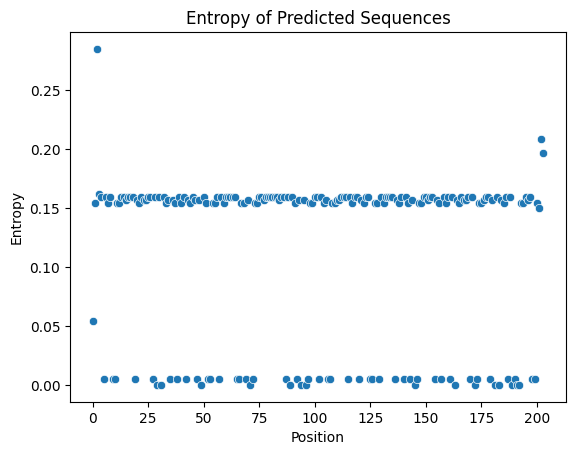

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

promoter_preds = [p[mask_start:mask_end] for p in predictions]

entropy = calculate_entropy(promoter_preds)
# Create a DataFrame to store the entropy values
entropy_df = pd.DataFrame({
    'Position': list(range(len(entropy))),
    'Entropy': entropy
})

sns.scatterplot(x='Position', y='Entropy', data=entropy_df)
plt.title('Entropy of Predicted Sequences')
plt.xlabel('Position')
plt.ylabel('Entropy')
plt.show()

## Original vector, median promoter sequence with masking

In [2]:
# Load the YFP vector dataset
yfp_vector = load_dataset("wconnell/openplasmid")
yfp_vector = yfp_vector.filter(lambda x: '127546' == x['ID'])
yfp_vector = yfp_vector['train'][0]

# Parse the GenBank file
yfp_gbank = read_genbank(yfp_vector['GenBank Raw'])

# Convert GenBank to GLM2 sequence
yfp_glm2 = genbank_to_glm2(yfp_vector['GenBank Raw'])

Filter:  15%|█▍        | 22000/147071 [00:02<00:14, 8430.13 examples/s]

In [ ]:
import random

def mask_promoter(promoter_seq, mask_frac=0.15):
    # Randomly replace n% of promoter_seq positions with '<mask>'
    masked_promoter = list(promoter_seq)
    mask_positions = random.sample(range(len(promoter_seq)), k=int(mask_frac * len(promoter_seq)))
    for pos in mask_positions:
        masked_promoter[pos] = '<mask>'
    masked_promoter = ''.join(masked_promoter)
    return masked_promoter


# Find the promoter site
# percentile = 25
# promoter_seq = 'TGCATTTTTTTCACATCTGTTAATAAGCGCGATAGCTTTTTAATAATTGCGAATGCATACAAACTGGCAATATTGATCCTTGGCATGCCGTGTAACAGGTTACGGCTGTT'.lower()
# percentile = 50
# promoter_seq = 'TGCATTTTTTTCACATCATGATACTTACGCAGTCGGTCTATGCCAGCGCGGAGAATAGGTTATTGCCCGTATGGCAAATCGATAGCCTGGTGACAGGGGTTACGGCTGTT'.lower()
percentile = 75
promoter_seq = 'TGCATTTTTTTCACATCGTTTCTCTGATACGGCGGGGTTATTTTTCGCGGATTTCTCCACATCGTTTAGAGATAACACTTCCAAGCTCGTTCCTTGGGGTTACGGCTGTT'.lower()

# Find the primer binding site
primer_bind = yfp_gbank.features[6]
primer_bind_seq = str(yfp_gbank.seq[primer_bind.location.start:primer_bind.location.end].lower())

# Insert the promoter seq
mask_start = yfp_glm2.find(primer_bind_seq)
mask_start = mask_start + len(primer_bind_seq) + 3  # buffer for '<+>'
mask_end = mask_start + len(promoter_seq)   

# Create masked_yfp_var_glm2 for all sequences
variant_promoters = []
n_samples = 2500

for i in range(n_samples):
    masked_promoter = mask_promoter(promoter_seq, mask_frac=0.15)
    masked_yfp_glm2 = yfp_glm2[:mask_start] + masked_promoter + '<+>' + yfp_glm2[mask_start:]
    variant_promoters.append({'ID': i, 'glm2_sequence': masked_yfp_glm2})

In [ ]:
from datasets import Dataset
from torch.utils.data import DataLoader
variant_promoter_ds = Dataset.from_list(variant_promoters)
variant_promoter_ds = variant_promoter_ds.map(tokenize_function, batched=True)
variant_promoter_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ID'])
dataloader = DataLoader(variant_promoter_ds, batch_size=16, shuffle=False)
    

Map: 100%|██████████| 2500/2500 [00:05<00:00, 492.27 examples/s]


In [ ]:
# Set the model to evaluation mode
device = 'cuda:1'
_ = model.to(device)
_ = model.eval()

predictions = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        logits = outputs.logits
        
        # Generate predicted sequences
        predicted_token_ids = torch.argmax(logits, dim=-1)
        predicted_sequences = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=False)
        # replace ' ' with ''
        predicted_sequences = [p.replace(" ", "") for p in predicted_sequences]
        predictions.extend(predicted_sequences)
    # if i == 10:
    #     break

# Print a sample of predictions
print("Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(pred)

Sample predictions:
<+>gaagcgcctacgcttgacatctactatatgtaagtatacggccccatatataggccctttcgtctcgcgcgtttcggtgatgacggtgaaaa<+>cctctgacacatgcagctcccgg<+>atttaggtgacactataga<+>atttaggtgacactatag<+>ttcaattcatcatttttttttttttctttttttttatttcggtttccttgaaatttttttgattcggtaatctccgaacagaaggaagaacgaaggaaggagcacagacttagattggtatatatatgcatatgtagtgttgaagaaacatgaaattgcccagtattcttaacccaactgcacagaacaaaaacctgcaggaaacgaagataaatc<+>MSKATYKERVATHPSPVAAKLFNIMHEKQTNLCASLDVRNTKELLELVEALGPKICLLKTHVDILTDFSMEGGVKALKALSAKYNFLLFEDRKFADIGNTVKLQYSAGVYRIAEWADITNAHGVVGPGIVSGLKQAAEEVTKEPRGLLMLAELSCKGSLSTGEYTKSVVEIAKQDPDFVIGFIAQRDMGGRDEGSDFLIATPGVGLDDKGDALGQQYRTVDDVVNTGSDILIVGRGLFAKGRDAKVEAERLRKAGWEAYLRRTGQQN<+>ccagtttggaacaagagtccac<+>tgcatttttttcacatcgtttctttgaaacggcggggttatttttcccggagttctccacatcgtttagaaaaatcacttcaaagctctttccttgatgttatggctgcg<+>MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKLICTTGKLPVPWPTLVTTLTYGLQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGGVQLADHYQQNT

In [ ]:
for p in predictions[:10]:
    print(p[mask_start:mask_end])

tgcatttttttcacatcgtttctttgaaacggcggggttatttttcccggagttctccacatcgtttagaaaaatcacttcaaagctctttccttgatgttatggctgcg
cttttttttcacaccgtgtctctgatacggcggggttatttttcgcggatttttccacatcgtgaagagaaaaaacttccaagttctttccttgaggttatggctgtt<+
ggcatttttttcacattttttctctgatacggcggtgttatttttctcggatttctccacatcgtttagagataacacctccaagctcgtgccttggggtcagggctgtg
catttttttcacatcgt<+>tctctgatacggcggggttatttttcgcggatttctcgacgtcgttttgagatcactcttcaaagttcgttcctggtggtttcggctttt
catttttttcagatcctttttcagatatggtggggttatttttcgcggatttctccacgtcgttttgagataaaactttcaagctctttccttggggttacggctgtg<+
cattttttttacatcgtttctctgacacggtggggtaatttttcgcggatttctccacatcgtttagagaaaaaatttccaagctcgttccttggggttacggctttt<+
ttcttttttttcacatcgtttctctgatatgttgggggtatttttgggggatttctcctcatcgtttacagttaacacttccaagctttttccttggggttacggctgtt
tgcatttttttcacatagtttttctgatacggggaggttatttttcgcggattcctccacatcctgaagagaaatcacttcaaaactcgttccttgggggtactgctgtt
ggcatttttttcacgtcgtttctctgatacggcgtggttatttttcgcgggttcctccacatcctctagaaatcacacttcccaactggttcctgggggttactgctgtt
t

<Axes: xlabel='Position', ylabel='Entropy'>

Text(0.5, 1.0, 'Entropy of Predicted Sequences')

Text(0.5, 0, 'Position')

Text(0, 0.5, 'Entropy')

Text(0.5, 1.0, 'Sequence entropy, 75th percentile sequence seed')

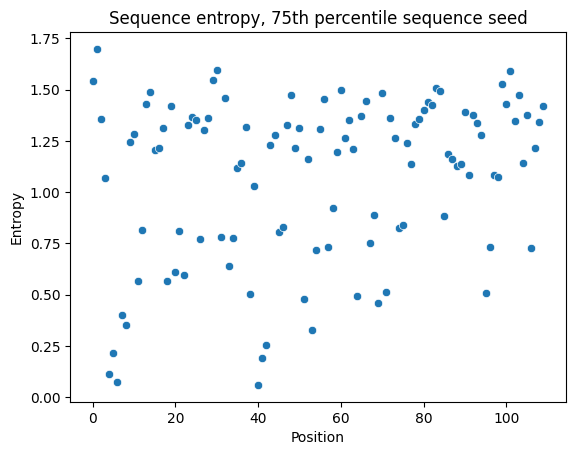

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

promoter_preds = [p[mask_start:mask_end] for p in predictions]

entropy = calculate_entropy(promoter_preds)
# Create a DataFrame to store the entropy values
entropy_df = pd.DataFrame({
    'Position': list(range(len(entropy))),
    'Entropy': entropy
})

sns.scatterplot(x='Position', y='Entropy', data=entropy_df)
plt.title('Entropy of Predicted Sequences')
plt.xlabel('Position')
plt.ylabel('Entropy')
plt.title(f'Sequence entropy, {percentile}th percentile sequence seed')
plt.savefig(f'results/gen_prom/entropy_{percentile}.png')
plt.show()

In [160]:
import re

# remove all non ACGTN characters
clean_promoter_preds = [re.sub(r'[^acgtn]', '', p).upper() for p in promoter_preds]
df = pd.DataFrame({'seq': clean_promoter_preds, 'bin': [0]*len(clean_promoter_preds)})
df.head()
df.to_csv(f"results/gen_prom/seqs_{percentile}.txt", sep='\t', index=False, header=False)

,seq,bin
0,TGCATTTTTTTCACATCGTTTCTTTGAAACGGCGGGGTTATTTTTC...,0
1,CTTTTTTTTCACACCGTGTCTCTGATACGGCGGGGTTATTTTTCGC...,0
2,GGCATTTTTTTCACATTTTTTCTCTGATACGGCGGTGTTATTTTTC...,0
3,CATTTTTTTCACATCGTTCTCTGATACGGCGGGGTTATTTTTCGCG...,0
4,CATTTTTTTCAGATCCTTTTTCAGATATGGTGGGGTTATTTTTCGC...,0
